<h1>Moosinator 10,000</h1>
<h3>Turning cat audio into melspectrographic images for training</h3>


In [16]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
from PIL import Image
import os

def audio_to_image(path, height=192, width=192):
    signal, sr = lr.load(path, res_type='kaiser_fast')
    hl = signal.shape[0]//(width*1.1)
    spec = lr.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))
    img = lr.power_to_db(spec)**2
    start = (img.shape[1] - width) // 2
    return img[:, start:start+width]

meow_images = []

for i in range(1,200):
    filename = 'data/cat_'+str(i)+'.wav'
    if Path('./'+filename).exists():
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            img = audio_to_image(filename)
            meow_images.append(img)
            
            # Uncomment this code to save new data
            #plt.imshow(img)
            #plt.savefig('training/cat_'+str(i)+'.png')

<h3>Building the CNN</h3>

In [17]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# image size: 432x288
height = 432
width = 288

#Initialising the CNN
model = Sequential()
# Step 1 - Convolution
model.add(Convolution2D(32, 3, 3, input_shape = (height,width, 3), activation = 'relu'))
# Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
model.add(Convolution2D(32, 3, 3, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
model.add(Flatten())
# Step 4 - Full connection
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

<h3>Filter training images to the CNN</h3>

In [18]:
from keras.preprocessing.image import ImageDataGenerator

#os.path.join(self.pos_dir, self.pos_labels.iloc[idx, 0])

# Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(r"./images/training/",
                                                 target_size = (height,width),
                                                 batch_size = 32, #32
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(r"./images/test/",
                                            target_size = (height,width),
                                            batch_size = 32, #32
                                            class_mode = 'binary')

Found 146 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


<h3>Let's start the training!</h3>

In [19]:
epochs = 10
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint("./models/meow_model.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    training_set, epochs=epochs, callbacks=callbacks, validation_data=test_set,
)

Epoch 1/10
5/5 [==============================] - 3s 499ms/step - loss: 0.0901 - accuracy: 0.9932 - val_loss: 1.5219 - val_accuracy: 0.8889
Epoch 2/10
5/5 [==============================] - 2s 462ms/step - loss: 0.1451 - accuracy: 0.9932 - val_loss: 2.0753 - val_accuracy: 0.8889
Epoch 3/10
5/5 [==============================] - 2s 401ms/step - loss: 0.1207 - accuracy: 0.9932 - val_loss: 1.3292 - val_accuracy: 0.8889
Epoch 4/10
5/5 [==============================] - 2s 534ms/step - loss: 0.0670 - accuracy: 0.9932 - val_loss: 0.8695 - val_accuracy: 0.8889
Epoch 5/10
5/5 [==============================] - 3s 518ms/step - loss: 0.0457 - accuracy: 0.9932 - val_loss: 0.5506 - val_accuracy: 0.8889
Epoch 6/10
5/5 [==============================] - 2s 475ms/step - loss: 0.0569 - accuracy: 0.9932 - val_loss: 0.4717 - val_accuracy: 0.8889
Epoch 7/10
5/5 [==============================] - 2s 475ms/step - loss: 0.0467 - accuracy: 0.9932 - val_loss: 0.6241 - val_accuracy: 0.8889
Epoch 8/10
5/5 [====

<h3>Loading the model</h3>

If you've already trained the model, you can skip the above cell and jump straight to this part.

In [20]:
model = keras.models.load_model('models/meow_model.h5')

<h3>Running the model on new data</h3>

probability of meow: 100.0%


C:\Users\gunra\AppData\Local\Temp\ipykernel_21348\2539681325.py:12: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spec = lr.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))


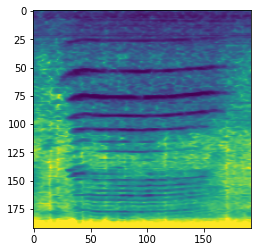

In [21]:
import tensorflow as tf

def run_inference_on_new_data(path):
    img = audio_to_image(path)
    plt.imshow(img)
    plt.savefig('images_to_analyze/meow'+'.png')

    # classify this image as a meow or not
    image_size = (432, 288)
    img = keras.preprocessing.image.load_img('images_to_analyze/meow.png', target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    score = predictions[0]
    return score

probability_of_meow = run_inference_on_new_data('./audio_to_analyze/meow.wav')[0]
percentage = str(100 * (1 - probability_of_meow)) + '%'
print ('probability of meow:', percentage)

